<a href="https://colab.research.google.com/github/nikag2006/cap-comp215/blob/main-lab/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 1
----------------
#### Name: Nika Ghassemi
#### Date: Wed Jan 7 2026

This lab exercise is mostly to introduce some of the power in Jupyter Notebooks.
Note that a Notebook is composed of "cells" - some are "text", like this one, while others are "code"

##### Lab Objectives

* create a 2D time-series plot of earthquake data
* review common data types (`int` and `str`) and data structures (`list` and `dict`)
* introduce a few new python programming techniques

**New Python Concepts**:
* *list comprehension* provides a compact way to represent map and filter algorithms
* `zip` is a built-in algorithm for combining "parallel" linear data structures
* `datetime.date` objects represent a calendar date (these are very powerful)

As will be usual, the fist code cell, below, simply imports all the modules we'll be using...

In [ ]:
import json, requests
import matplotlib.pyplot as plt
import  matplotlib.dates as mdates
from datetime import datetime
from pprint import pprint    # Pretty Print - built-in python function to nicely format data structures

2### Making an API Query
We'll start by fetching and inspecting some earthquake data from the USGS API

Goals:
- Make an API request
- Convert the JSON response into a Python dictionary
- Inspect the structure of the returned data

USGS API Documentation:  https://earthquake.usgs.gov/fdsnws/event/1/#parameters

Our first query:
  - `format=geojson`       # the format we want the data in
  - `starttime=2022-01-01` # the start date (date format: yyyy-mm-dd)
  - `minmagnitude=5.0`   # smallest magnitude earthquake we're interested in

In [ ]:
USGS_API_URL = "https://earthquake.usgs.gov/fdsnws/event/1/query"

params = dict(
    format="geojson",
    starttime="2022-01-01",
    minmagnitude=5.0,
)

# make a request (like browsing to a web page) and print the results
response = requests.get(USGS_API_URL, params=params)

print('Response data type:', type(response.text))
response.text[:1000]

Response data type: <class 'str'>


'{"type":"FeatureCollection","metadata":{"generated":1767833593000,"url":"https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2022-01-01&minmagnitude=5.0","title":"USGS Earthquakes","status":200,"api":"1.14.1","count":7179},"features":[{"type":"Feature","properties":{"mag":5.5,"place":"south of the Fiji Islands","time":1767823213258,"updated":1767832011480,"tz":null,"url":"https://earthquake.usgs.gov/earthquakes/eventpage/us7000rnbi","detail":"https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us7000rnbi&format=geojson","felt":null,"cdi":null,"mmi":1,"alert":"green","status":"reviewed","tsunami":0,"sig":465,"net":"us","code":"7000rnbi","ids":",usauto7000rnbi,us7000rnbi,","sources":",usauto,us,","types":",internal-moment-tensor,losspager,moment-tensor,origin,phase-data,shakemap,","nst":63,"dmin":5.976,"rms":1.13,"gap":39,"magType":"mww","type":"earthquake","title":"M 5.5 - south of the Fiji Islands"},"geometry":{"type":"Point","coordinates":[-179.8984,-23.433

Notice that the response looks like a dictionary, but is actually just a string of text (most data on the web is exchanged as plain text!).  This particular data format is called "[JSON](https://en.wikipedia.org/wiki/JSON)"

The `json.loads` function "parses" such text and loads the data into a dictionary...

In [ ]:
data = json.loads(response.text)
print(f"Query returned a dict with {len(data)} keys")
print(data.keys())   # pretty-print the keys from dict we got back...

Query returned a dict with 4 keys
dict_keys(['type', 'metadata', 'features', 'bbox'])


In [ ]:
# the list of earthquake data are under the "features" key...
earthquake_list = data["features"]
print(f"Query returned {len(earthquake_list)} earthquake records.")
# and here is what the start of that list of earthquake records looks like...
pprint(earthquake_list[:2])  # do you recall the "slice" operation?  If not, look it up in the ThinkCsPy textbook!

Query returned 7179 earthquake records.
[{'geometry': {'coordinates': [-179.8984, -23.4332, 547.033], 'type': 'Point'},
  'id': 'us7000rnbi',
  'properties': {'alert': 'green',
                 'cdi': None,
                 'code': '7000rnbi',
                 'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us7000rnbi&format=geojson',
                 'dmin': 5.976,
                 'felt': None,
                 'gap': 39,
                 'ids': ',usauto7000rnbi,us7000rnbi,',
                 'mag': 5.5,
                 'magType': 'mww',
                 'mmi': 1,
                 'net': 'us',
                 'nst': 63,
                 'place': 'south of the Fiji Islands',
                 'rms': 1.13,
                 'sig': 465,
                 'sources': ',usauto,us,',
                 'status': 'reviewed',
                 'time': 1767823213258,
                 'title': 'M 5.5 - south of the Fiji Islands',
                 'tsunami': 0,
                 '

#### Structured Data
Notice how the data is organized

- a dictionary with list of data "records"
- each data "record" describes one earthquake
- each "earthquake" is itself a dictionary of more dictionaries and lists

This is typical for API results: a `dict` of `list`s of `dict`s of `list`s of `dict`s

Understanding how data is structured is the first lesson for COMP215 - here we see how complex that can get even for a relatively simple data set.

### Extract earthquake data items from a list of dictionaries

Goals:

- create a data set suitable for counting the number of earthquakes per year
- introduction to "list comprehension"
- introduction to `datetime` objects

We will use "list comprehension" to extract the list of dates and associated quake magnitude into "parallel lists".

In [ ]:
quake_timestamps = [quake['properties']['time'] for quake in earthquake_list] # List Comprehension #1: extract timestamps
quake_mags = [quake['properties']['mag'] for quake in earthquake_list] # List Comprehension #2:  extract the magnitudes

print('Timestamps:', quake_timestamps[:5])
print('Magnitudes:', quake_mags[:5])

Timestamps: [1767823213258, 1767759176792, 1767754976040, 1767741038371, 1767727029696]
Magnitudes: [5.5, 5.5, 6.4, 5, 5.2]


### Datetime.date
Working with date strings is a pain.  So many formats!  Even within Canada, you might see:
"Jan. 9, 2023" or "09-01-2023" or "2023-01-09" or ....
Imagine trying to do a calculation like "how many days between these 2 dates"!!

The build-in `datetime` package makes working with dates much easier.
  * construct a `datetime` object from a "timestamp"  (typically the number of seconds since "epoch")
  * "parse" the date string data (`strptime` ==  "string-parse-datetime object")
  * get parts of the date (i.e., just the date without the time, or even just the year or month)

In [ ]:
# construct a datetime object from the "timestamp" - convert from ms to seconds, then convert from timestamp to datetime
quake_dates = [
    datetime.fromtimestamp(timestamp/1000) for timestamp in quake_timestamps
]  # List Comprehension #3: transform each timestamp into a datetime object

# but we only want the "year" part...
quake_years = [dt.year for dt in quake_dates]  # List Comprehension #4: extrac year from each date
quake_years[:5]

[2026, 2026, 2026, 2026, 2026]

In [ ]:
# Now "zip" the year and magnitude data back together - this is a "parallel list" operation
#     "zip" takes 2 or more lists and "zips" them together like a zipper - look it up!
print('Zipped:')
pprint(list(zip(quake_years[:5], quake_mags[:5])))

Zipped:
[(2026, 5.5), (2026, 5.5), (2026, 6.4), (2026, 5), (2026, 5.2)]


## Exercise 1 : loops vs. comprehensions

In the code cell below, re-write the "List Comprehensions" above using one or more`for` loops so you understand how they work.

Goal:

- replicate the final zipped list of 2-tuples (year, magnitude) using the "list accumulator" algorithm you learned in 115

Compare to see how a "list comprehension" is a compact way to write a "list accumulator" algorithm (and more efficient too!)

In [ ]:
# Ex. 1 your code here
mag_by_year = []
for quake in earthquake_list:
    timestamp = quake['properties']['time']
    mag = quake['properties']['mag']
    dt = datetime.fromtimestamp(timestamp/1000)
    year = dt.year
    mag_by_year.append((year, mag))

pprint(mag_by_year[:5])

[(2026, 5.5), (2026, 5.5), (2026, 6.4), (2026, 5), (2026, 5.2)]


## Exercise 2:  counting dates

In the code cell below, write an algorithm that counts the number of quakes in each year.

Goal:

- produce a dictionary that maps each year in the data set to a count of the number of quakes in that year
- an mock example of the data structure you are aiming for is given below

_Hints_:

- this is also an "accumulator" algorithm, where you are accumulating a count for each year
- a `defaultdict` can simplify the algorithm - look it up if you are interested (not required)


In [ ]:
# Ex. 2 your code here
earthquake_counts = {}
for year, mag in mag_by_year:
    if year in earthquake_counts:
        earthquake_counts[year] += 1
    else:
        earthquake_counts[year] = 1

pprint(earthquake_counts)

# Replace this "mock" data with your results - these data are plotted in next step...
earthquake_counts = {
    2022: 10,
    2023: 25,
    2024: 15,
    2025: 18,
}

{2022: 1725, 2023: 1779, 2024: 1506, 2025: 2128, 2026: 36}


### Generating a plot

Finally, we'll plot the (year, earthquake_count) data as a nice x-y line graph....

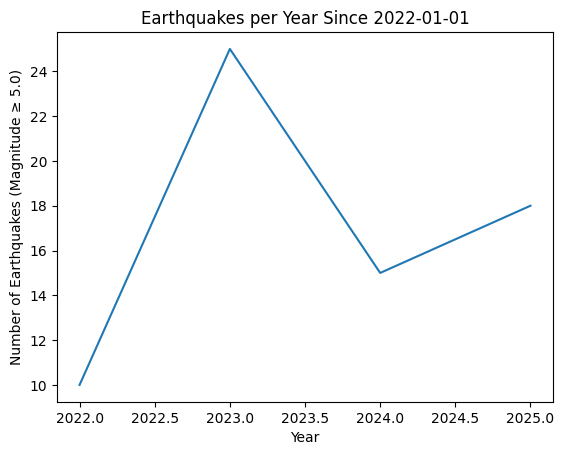

In [ ]:
plt.figure()
plt.plot(earthquake_counts.keys(), earthquake_counts.values())
plt.xlabel("Year")
plt.ylabel(f"Number of Earthquakes (Magnitude ≥ {params['minmagnitude']})")
plt.title(f"Earthquakes per Year Since {params['starttime']}")
plt.show()

## Exercise 3: re-run the analysis for a different data set

Repeat the analysis above, but this time for large-magnitude earthquakes (e.g., >=7) over a longer timespan (e.g., since 1970).
(Note that the API limits results to 20,000 records, if it fails, reduce the size of your query.)

* Just re-run the analysis with new parameters!
* Submit your lab workbook run with your final analysis parameters


In [ ]:
USGS_API_URL = "https://earthquake.usgs.gov/fdsnws/event/1/query"

params = dict(
    format="geojson",
    starttime="1970-01-01",
    minmagnitude=7.0,
)

# make a request (like browsing to a web page) and print the results
response = requests.get(USGS_API_URL, params=params)

print('Response data type:', type(response.text))
response.text[:1000]

Response data type: <class 'str'>


'{"type":"FeatureCollection","metadata":{"generated":1767828126000,"url":"https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=1970-01-01&minmagnitude=7.0","title":"USGS Earthquakes","status":200,"api":"1.14.1","count":773},"features":[{"type":"Feature","properties":{"mag":7.6,"place":"2025 Aomori Prefecture, Japan Earthquake","time":1765203310397,"updated":1767717524892,"tz":null,"url":"https://earthquake.usgs.gov/earthquakes/eventpage/us6000rtdt","detail":"https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us6000rtdt&format=geojson","felt":255,"cdi":7.4,"mmi":6.911,"alert":"yellow","status":"reviewed","tsunami":1,"sig":1077,"net":"us","code":"6000rtdt","ids":",at00t6yfla,pt25342050,us6000rtdt,usauto6000rtdt,","sources":",at,pt,us,usauto,","types":",dyfi,earthquake-name,finite-fault,ground-failure,impact-link,impact-text,internal-moment-tensor,internal-origin,losspager,moment-tensor,origin,phase-data,shakemap,","nst":171,"dmin":0.871,"rms":0.72,"gap":17,"mag

In [ ]:
data = json.loads(response.text)
print(f"Query returned a dict with {len(data)} keys")
print(data.keys())

Query returned a dict with 4 keys
dict_keys(['type', 'metadata', 'features', 'bbox'])


In [ ]:
earthquake_list = data["features"]
print(f"Query returned {len(earthquake_list)} earthquake records.")
pprint(earthquake_list[:2])

Query returned 773 earthquake records.
[{'geometry': {'coordinates': [142.1802, 40.9966, 45.351], 'type': 'Point'},
  'id': 'us6000rtdt',
  'properties': {'alert': 'yellow',
                 'cdi': 7.4,
                 'code': '6000rtdt',
                 'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us6000rtdt&format=geojson',
                 'dmin': 0.871,
                 'felt': 255,
                 'gap': 17,
                 'ids': ',at00t6yfla,pt25342050,us6000rtdt,usauto6000rtdt,',
                 'mag': 7.6,
                 'magType': 'mww',
                 'mmi': 6.911,
                 'net': 'us',
                 'nst': 171,
                 'place': '2025 Aomori Prefecture, Japan Earthquake',
                 'rms': 0.72,
                 'sig': 1077,
                 'sources': ',at,pt,us,usauto,',
                 'status': 'reviewed',
                 'time': 1765203310397,
                 'title': 'M 7.6 - 2025 Aomori Prefecture, Japan Ear

In [ ]:
quake_timestamps = [quake['properties']['time'] for quake in earthquake_list]
quake_mags = [quake['properties']['mag'] for quake in earthquake_list]

print('Timestamps:', quake_timestamps[:5])
print('Magnitudes:', quake_mags[:5])

Timestamps: [1765203310397, 1765053708011, 1760128160075, 1760060639585, 1758221894939]
Magnitudes: [7.6, 7, 7.6, 7.4, 7.8]


In [ ]:
# construct a datetime object from the "timestamp" - convert from ms to seconds, then convert from timestamp to datetime
quake_dates = [
    datetime.fromtimestamp(timestamp/1000) for timestamp in quake_timestamps
]

# but we only want the "year" part...
quake_years = [dt.year for dt in quake_dates]
quake_years[:5]

[2025, 2025, 2025, 2025, 2025]

In [ ]:
# Re-create mag_by_year using a loop
mag_by_year = []
for quake in earthquake_list:
    timestamp = quake['properties']['time']
    mag = quake['properties']['mag']
    dt = datetime.fromtimestamp(timestamp/1000)
    year = dt.year
    mag_by_year.append((year, mag))

pprint(mag_by_year[:5])

[(2025, 7.6), (2025, 7), (2025, 7.6), (2025, 7.4), (2025, 7.8)]


In [ ]:
# Re-calculate earthquake_counts
earthquake_counts = {}
for year, mag in mag_by_year:
    if year in earthquake_counts:
        earthquake_counts[year] += 1
    else:
        earthquake_counts[year] = 1

pprint(earthquake_counts)

{1970: 17,
 1971: 11,
 1972: 15,
 1973: 9,
 1974: 11,
 1975: 13,
 1976: 14,
 1977: 11,
 1978: 12,
 1979: 8,
 1980: 6,
 1981: 10,
 1982: 8,
 1983: 14,
 1984: 14,
 1985: 15,
 1986: 11,
 1987: 13,
 1988: 11,
 1989: 8,
 1990: 18,
 1991: 17,
 1992: 13,
 1993: 12,
 1994: 13,
 1995: 20,
 1996: 15,
 1997: 16,
 1998: 12,
 1999: 18,
 2000: 15,
 2001: 15,
 2002: 13,
 2003: 15,
 2004: 16,
 2005: 11,
 2006: 11,
 2007: 18,
 2008: 12,
 2009: 17,
 2010: 24,
 2011: 20,
 2012: 17,
 2013: 19,
 2014: 12,
 2015: 19,
 2016: 16,
 2017: 7,
 2018: 17,
 2019: 10,
 2020: 9,
 2021: 19,
 2022: 11,
 2023: 19,
 2024: 10,
 2025: 16}


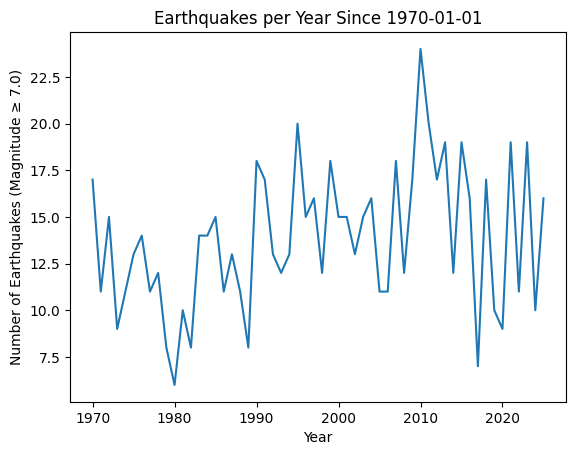

In [ ]:
plt.figure()
plt.plot(earthquake_counts.keys(), earthquake_counts.values())
plt.xlabel("Year")
plt.ylabel(f"Number of Earthquakes (Magnitude ≥ {params['minmagnitude']})")
plt.title(f"Earthquakes per Year Since {params['starttime']}")
plt.show()

## Challenge Exercises (optional) - Take your skills to the next level...

## Exercise 4: Earthquakes by month

1. re-do the data transformations to extract (dt.year, dt.month) 2-tuples from each earthquake timestamp
2. re-do the count analysis to tally the number of quakes in each month
3. create a new plot with the number of quakes per month

- Develop all the code for this exercise in one or more code blocks below.
- You may copy any of the code from blocks above, then revise it to do the monthly analysis.
- Change the variable names you use (e.g., `quake_months` instead of `quake_years`) to avoid getting confused

#### Exercise 5: Smoothing function super-challenge!

Notice that the data plot looks quite erratic.  Earthquakes are "self-organizing", "critical" systems, which we'll learn
more about later in the term.  Their erratic behaviour makes it hard to spot long-term trends.

 * One technique to help highlight trends is to "smooth" the data using a "6-month rolling average".
Each month, we take the average of the previous 6 months of earthquake counts.
 * Add new code cell below, compute the 6-month rolling average for each month from the raw monthly count data.
 * Create a plot to display the rolling average data and compare your plot with the one produced in Ex. 4.

 Hints: you are free to do this however you like, but a quite elegant solution uses list comprehension, range, and slices

In [ ]:
# Ex. 4 (challenge) your code here